# CSCI 4253 Final Project
# Machine Learning Prototype

Brief note on the following. We compare a couple of machine learning models to see which one feels better for the situation based on metrics and ease of use. 

Note that as this is not a machine learning course, the level of performance metrics and testing is not deeply intensive, rather simple to quickly determine which model to choose.

We have decided on using: KNN

In [20]:
import io
import boto3
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import preprocessing

<br><br><br><br>
## Import Data
***
Please change the configuration below for your own local settings. Currently this is importing a CSV file from an AWS S3 bucket.

In [3]:
s3 = boto3.client('s3')
file = s3.get_object(Bucket = 'csci4253-final-project-ms', Key = 'msds_full.csv')
df_all = pd.read_csv(io.BytesIO(file['Body'].read()))
print("Done!")

Done!


Use the code below for testing with a local csv file:

In [3]:
# df_all = pd.read_csv("music.csv")
df_all = pd.read_csv("data/msds.csv")
print("Done!")

Done!


In [4]:
df_all.shape

(1000000, 21)

<br><br><br><br>
## Process the data
***
Remove or configure any additional input features below.

The following features are currently being analyzed as input features:
- energy (not available in data set currently but will add it for next checkpoint)
- duration
- beats_start (number of beats in a song)
- loudness
- tempo
- year
- mode
- key

The output feature is:
- song_hotttnesss

For descriptions, please see: https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description.

#### Below is a preview of the dataset

In [8]:
df_all.head()

,index,artist_name,danceability,duration,end_of_fade_in,energy,key,key_confidence,loudness,mode,...,artist_hotttness,song_hotttness,start_of_fade_out,tempo,time_signature,time_signature_confidence,title,release,year,track_id
0,0,Baka Beyond,0.0,368.14322,0.000,0.0,9,0.588,-11.482,0,...,0.391484,0.355286,358.905,139.092,4,0.000,Journey (Album Version),The Meeting Pool,1995,TRCCCRP128F147BEFA
1,1,The Fleetwoods,0.0,175.59465,0.374,0.0,5,0.595,-15.193,1,...,0.397711,0.310792,160.142,87.650,4,0.769,Ten Times Blue,Come Softly To Me: The Very Best Of The Fleetw...,1993,TRCCCDI128F427CC1F
2,2,Joe Satriani,0.0,254.85016,0.113,0.0,7,0.100,-4.707,1,...,0.620948,0.693272,238.939,87.875,4,0.895,It's So Good,Super Colossal,2006,TRCCCMQ128F42AE752
3,3,BIZ,0.0,233.40363,1.245,0.0,9,0.783,-5.972,1,...,0.288014,NaN,229.808,97.997,4,0.624,Ghosts,Long Way Down Single,0,TRCCCKF128F424C3D3
4,4,Memphis Slim,0.0,110.62812,0.502,0.0,5,0.669,-20.100,1,...,0.394463,NaN,105.401,200.962,1,0.000,Baby Please Come Home,Essential Blues Grooves Vol. 1,0,TRCCCFH12903CEBC70


#### This is a preview of the input features (and output) that we are using for our data set. Notice that the amout of data missing a "hotttnesss" score is relatively large. This can impact the final accuracy and an alternative method should be considered.

In [124]:
df = df_all[['index',
             'artist_name',
             'danceability',
             'duration',
             'end_of_fade_in',
             'energy',
             'key',
             'key_confidence',
             'loudness',
             'mode',
             'mode_confidence',
             'artist_hotttness',
             'song_hotttness',
             'start_of_fade_out',
             'tempo',
             'time_signature',
             'time_signature_confidence',
             'title',
             'release',
             'year']]
df = df.dropna()
# song_without_year = df[df.year == 0].iloc[0]
song_without_year = df[(df.title == "Day Is Done") & (df.artist_name == "Ryan Bingham")]

# Turn string into numerical features so they can be trained on by the ML model.
artist_encoder = preprocessing.LabelEncoder()
df['artist_name'] = artist_encoder.fit_transform(df['artist_name'])

title_encoder = preprocessing.LabelEncoder()
df['title'] = title_encoder.fit_transform(df['title'])

release_encoder = preprocessing.LabelEncoder()
df['release'] = release_encoder.fit_transform(df['release'])


print(df.head())
print("There are", df.shape[0], "data points.")

   index  artist_name  danceability   duration  end_of_fade_in  energy  key  \
0      0         3757           0.0  368.14322           0.000     0.0    9   
1      1        44826           0.0  175.59465           0.374     0.0    5   
2      2        22379           0.0  254.85016           0.113     0.0    7   
6      6        30345           0.0  188.49914           6.432     0.0    2   
8      8        32578           0.0  276.53179           4.963     0.0    3   

   key_confidence  loudness  mode  mode_confidence  artist_hotttness  \
0           0.588   -11.482     0            0.367          0.391484   
1           0.595   -15.193     1            0.519          0.397711   
2           0.100    -4.707     1            0.393          0.620948   
6           0.356    -7.202     1            0.462          0.392012   
8           0.170    -8.107     0            0.031          0.372731   

   song_hotttness  start_of_fade_out    tempo  time_signature  \
0        0.355286          

#### While looking at the year, it appears that over many datapoints of the sample do not have a year. This would be too little data - so for now the year will be removed. However, it is still a possibility that we could get the year through another service, or draw more data which has the year available.

In [36]:
# Can also use .sample(x) to get x random data points
df = df[df.year != 0]
print("There are", df.shape[0],"data points")

There are 346444 data points


In [37]:
X_all = df.drop(columns=['song_hotttness'])
y_all = df['song_hotttness']

<br><br><br><br>
## Split the data
***
Split the data into training and testing. The model will train on the "training" data and then to test the accuracy we check how well the model performed in predicting the testing data.

For now, 80% of the data will be used for training.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size =0.2, random_state=39)
print("Done!")

Done!


For classification, we want labels, aka "hot" or "not hot" for our predictions. Below converts into binary labels based on a threshold which determines which songs are "hot".

In [39]:
threshold = 0.6
y_train_label = [y >= threshold for y in y_train]
y_test_label  = [y >= threshold for y in y_test]

<br><br><br><br>
## Train the model
***
For our model, since we are predicting a "hotness" score for an input. That is, given a plethora of data about a song, our model will take that and give a score in [0,1] which will represent how popular a song is.

Note we are comparing two different models below.

### K-Nearest-Neighbors (KNN)
Below, we are using k-nearest-neighbors, where we classify a song as popular based on proximity to other datapoints. We can also get a confidence score to based on proximity. For parameter tuning, we can also adjust the number of neighbours. 

Please see: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html for more information about KNN.

In [40]:
from sklearn.neighbors import KNeighborsClassifier

def createKnn(n_neighbors, X, y):
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(X,y)
    return knn

In [41]:
# E.g. to create a KNN model:
# knn = createKnn(3, X_train, y_train_label)
# print("Done!")

### Logistic Regression
Below, we are using logistic regression, where we classify a song as popular if its hotness >= x where x is between 0 and 1 (e.g. x = 0.6). This would tell us not only if a song will be popular, but give us a confidence score, similar to hotness. 

Please see: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for more information about LogisticRegression.

In [42]:
from sklearn.linear_model import LogisticRegression
def createLogReg(c, X, y):
    logReg = LogisticRegression(penalty = "l2", C=c)
    logReg.fit(X, y)
    return logReg

In [43]:
# E.g. to create a Logistic Regression model:
# logReg = createLogReg(X_train, y_train_logReg)
# print("Done!")

### Note on Linear Regression
We tried using multivariate linear regression but for now decided to stick with classification. This is for a couple of reasons. Ultimately, we wanted to predict if a song is "hot" or "not hot" which is binary classification. Classification seemed more appropriate here, where we can then assign a confidence score afterwards (logisitc regression does the same principle of regression, but with a confidence score and binary classification). Secondly, we wanted to make it easier to compare metrics and felt for now it would be most feasible to only use classification to assist in comparison.

For more information on Linear Regression in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

<br><br><br><br>
## Testing
***

### K-Nearest-Neighbors (KNN)

To tune KNN, we will adjust the number of neighbors and see how the performance is affected (analyzed in the metrics section below).

In [64]:
n_neighbors = range(1,25,2)
def train_knn(X_train, y_train, X_test, y_test):
    knn_accuracies_test = []
    knn_accuracies_train = []
    for n in n_neighbors:
#         print("Testing N =",n)
        knn = createKnn(n, X_train, y_train_label)
        y_predict_knn = knn.predict(X_test)
        knn_accuracies_test.append(accuracy_score(y_predict_knn, y_test_label))
        knn_accuracies_train.append(accuracy_score(knn.predict(X_train), y_train_label))
    return (knn_accuracies_test, knn_accuracies_train)
# train_knn(X_train, y_train_label, X_test, y_test_label)

### Determine which features to use
Lets test out the accuracy for many different feature sets and see the end result.

In [200]:
features_sets = [['artist_name', 'danceability', 'duration', 'end_of_fade_in', 'energy', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'artist_hotttness', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'title', 'release', 'year'],
#                  ['artist_name', 'danceability', 'duration', 'energy',  'loudness', 'artist_hotttness', 'tempo', 'title', 'release', 'year'],
                 ['artist_name', 'artist_hotttness'],
                 ['artist_name', 'artist_hotttness', 'year'],
                 ['duration', 'tempo', 'year'],
                 ['artist_name', 'artist_hotttness', 'duration'],
                 ['duration', 'year'],
                 ['loudness', 'year'],
                 ['tempo', 'year'],
                 ['duration', 'loudness', 'tempo', 'year'],
                 ['artist_name', 'artist_hotttness', 'duration', 'year'],
                 ['artist_name', 'artist_hotttness', 'loudness', 'year'],
                 ['artist_name', 'artist_hotttness', 'tempo', 'year'],
                 ['artist_name', 'artist_hotttness', 'duration', 'loudness', 'tempo', 'year']
                ]



In [201]:
total_train_accuracies = []
total_test_accuracies = []
for features in features_sets:
    print("Testing set:", features)
    newPoint = train_knn(X_train[features], y_train_label, X_test[features], y_test_label)
    total_train_accuracies.append(newPoint[1])
    total_test_accuracies.append(newPoint[0])
    
print("Done!")

Testing set: ['artist_name', 'danceability', 'duration', 'end_of_fade_in', 'energy', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'artist_hotttness', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'title', 'release', 'year']
Testing set: ['artist_name', 'artist_hotttness']
Testing set: ['artist_name', 'artist_hotttness', 'year']
Testing set: ['duration', 'tempo', 'year']
Testing set: ['artist_name', 'artist_hotttness', 'duration']
Testing set: ['duration', 'year']
Testing set: ['loudness', 'year']
Testing set: ['tempo', 'year']
Testing set: ['duration', 'loudness', 'tempo', 'year']
Testing set: ['artist_name', 'artist_hotttness', 'duration', 'year']
Testing set: ['artist_name', 'artist_hotttness', 'loudness', 'year']
Testing set: ['artist_name', 'artist_hotttness', 'tempo', 'year']
Testing set: ['artist_name', 'artist_hotttness', 'duration', 'loudness', 'tempo', 'year']
Done!


<br><br><br><br>
## Metrics
***
Below are graphs comparing accuracies for testing and training. Training data is analyzed to check for over-fitting. Note that these are very rough metrics and that more in-depth training could considered, albeit given the goal and time-constraints of this project, we will work with the following analysis.

### K-Nearest-Neighbors (KNN)

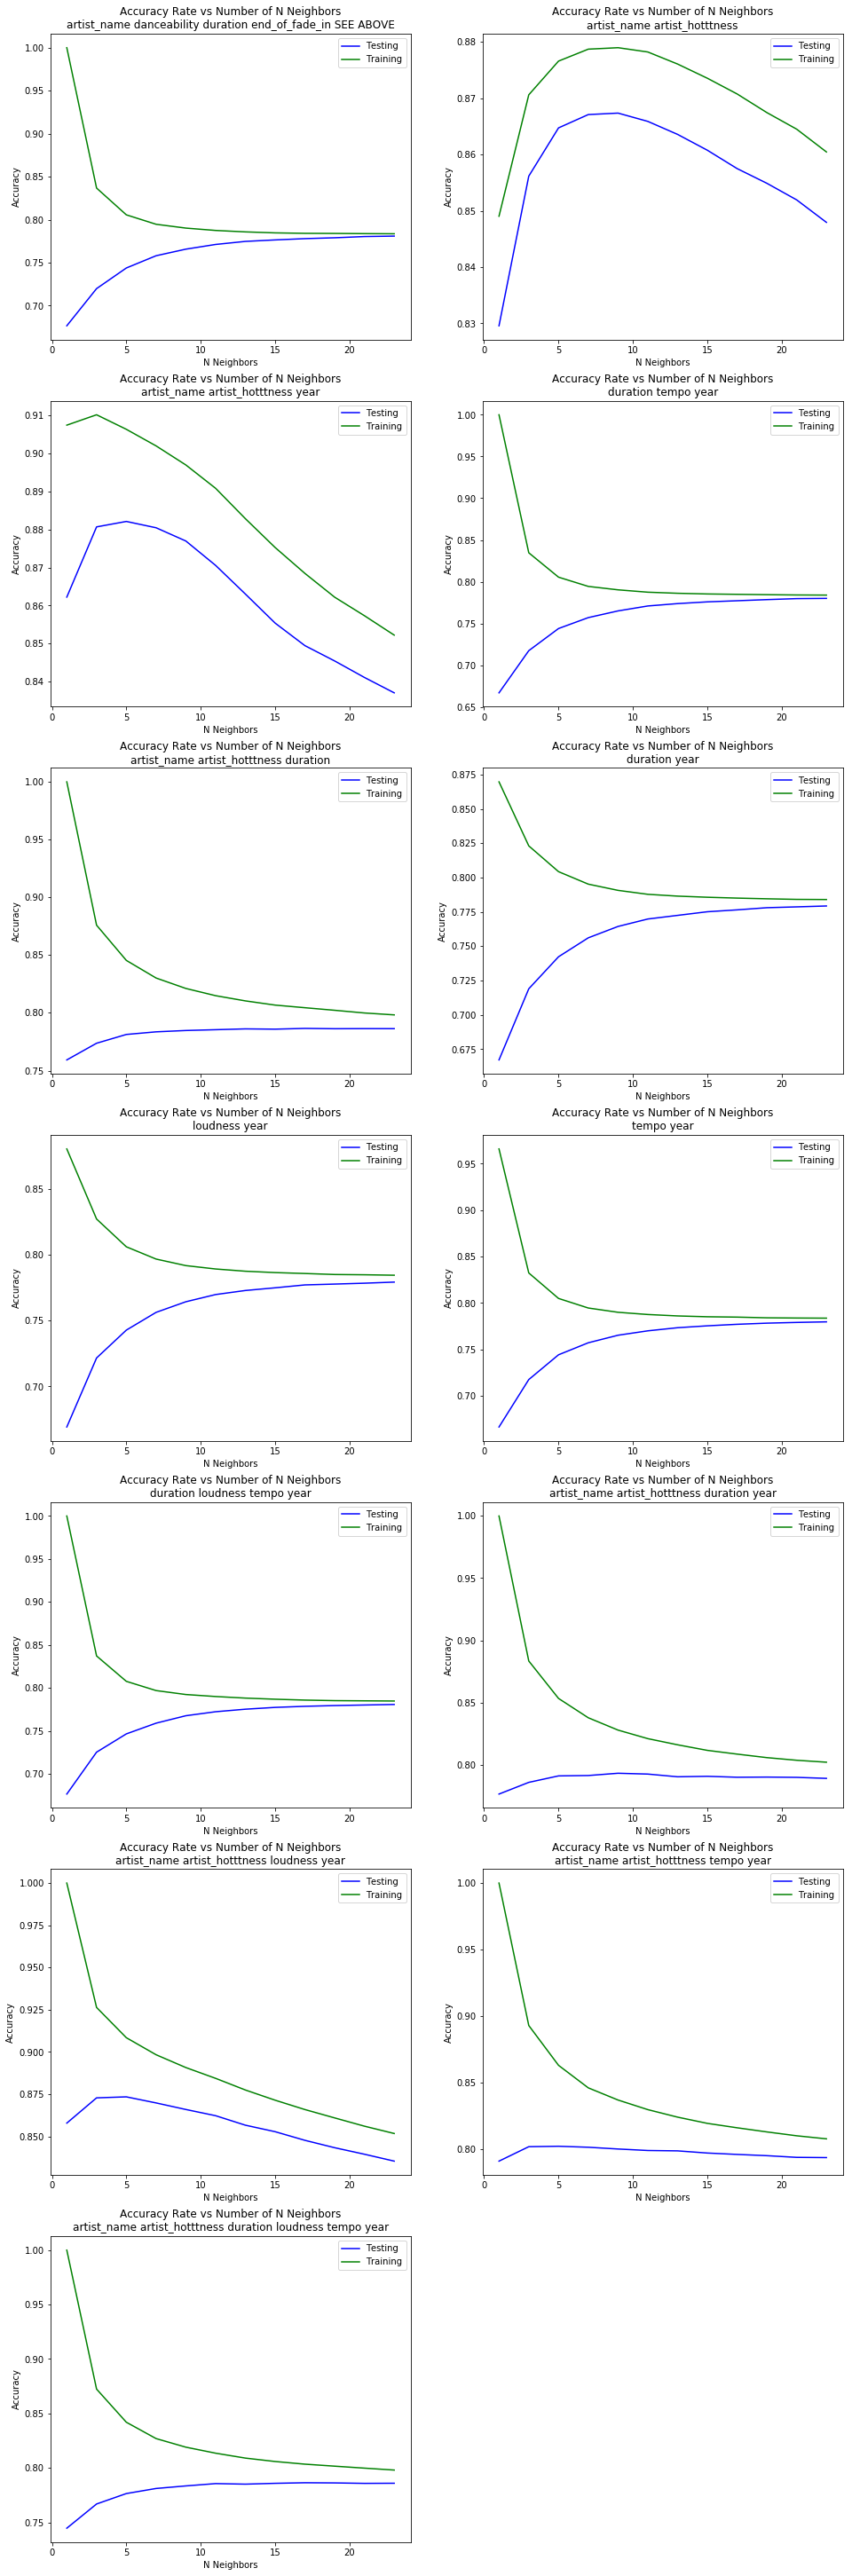

Done!


In [203]:
import math
import matplotlib.pylab as plt

l = len(total_train_accuracies)
plt.figure(figsize = (16,math.ceil(l) * 4))
rows = math.ceil(l * 0.5)
for i in range(l):
    plt.subplot(rows,2,i+1)
    plt.xlabel("N Neighbors")
    plt.ylabel("Accuracy")
    features = features_sets[i] if len(features_sets[i]) <=6 else features_sets[i][:4] + ["SEE ABOVE"]
    plt.title("Accuracy Rate vs Number of N Neighbors\n" + " ".join(features))
    plt.plot(n_neighbors, total_test_accuracies[i], color = "blue")
    plt.plot(n_neighbors, total_train_accuracies[i], color = "green")
    plt.legend(["Testing", "Training"])
plt.show()
print("Done!")


## Lets see if we can predict what year a song is most popular
We'll make predictions on a song over many years and see which year it has the highest chance of being popular.

In [209]:
n = 25
# print(song_without_year)
song_without_yearp = song_without_year.copy(True)
print(song_without_year.at[86,"artist_name"])
print(song_without_year.at[86,"title"])
print("Song came out in 2009")
      
      
song_without_yearp.at[86,"artist_name"] = artist_encoder.transform(song_without_year['artist_name'])
song_without_yearp.at[86,"title"] = title_encoder.transform(song_without_year['title'])
song_without_yearp.at[86,"release"] = release_encoder.transform(song_without_year['release'])

features = ['artist_name', 'artist_hotttness', 'duration','tempo', 'loudness', 'year']
knn = createKnn(n, X_train[features], y_train_label)
years = [i for i in range(1970, 2011, 2)];
predictions = []

for i in years:
    song_without_yearp.at[86, 'year'] = i
    predictions.append(knn.predict_proba(song_without_yearp[features]))
print("Done!")
print(song_without_year.T)
print(song_without_year[features].T)

Ryan Bingham
Day Is Done
Song came out in 2009
Done!
                                      86
index                                 86
artist_name                 Ryan Bingham
danceability                           0
duration                         265.195
end_of_fade_in                     0.589
energy                                 0
key                                    9
key_confidence                     0.007
loudness                          -6.991
mode                                   1
mode_confidence                    0.074
artist_hotttness                0.468743
song_hotttness                  0.624834
start_of_fade_out                239.851
tempo                             90.541
time_signature                         4
time_signature_confidence          0.699
title                        Day Is Done
release                    Roadhouse Sun
year                                2009
                            86
artist_name       Ryan Bingham
artist_hotttness      0.

In [205]:
# predictions_score = [predictions[i][0] for i in range(len(predictions))]
# predictions[20][0]
# predictions_score
predictions_score = []
for i in range(len(predictions)):
    predictions_score.append(predictions[i][0][0])
predictions_score

[0.68,
 0.64,
 0.64,
 0.64,
 0.64,
 0.64,
 0.64,
 0.6,
 0.6,
 0.56,
 0.56,
 0.56,
 0.6,
 0.56,
 0.56,
 0.56,
 0.52,
 0.52,
 0.52,
 0.52,
 0.52]

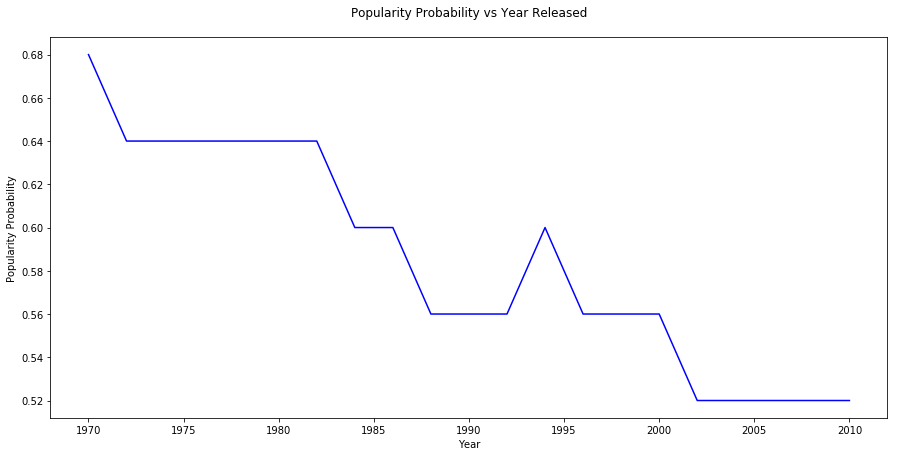

In [206]:
l = len(total_train_accuracies)
plt.figure(figsize = (15,7))
plt.xlabel("Year")
plt.ylabel("Popularity Probability")
plt.title("Popularity Probability vs Year Released\n")
plt.plot(years, predictions_score, color = "blue")
plt.show()

## Conclusion
***

After using more data, it appears that ~25 neighbours is optimal compared to the 7 neighbours before. Also we found that artist_name, artist_hotttness, duration, energy and year of the song released were good indicators for the wether the song would be popular or not. Keep in mind that using all the attributes provided 